# Tutorial 4: Integration of slide-DNA-seq and slide-RNA-seq mouse liver metastasis slices

This tutorial demonstrates STAOmics’s ablility to integrate spatial DNA-seq and RNA-seq slices. The raw and processed data can be downloaded from https://singlecell.broadinstitute.org/single_cell/study/SCP1278 and https://drive.google.com/drive/folders/1GNipnqXwwf5Ojv-6mTPyVeWCjFEYmlV6?usp=sharing, respectively.

In [1]:
import warnings
warnings.filterwarnings('ignore')

## setting for bedtools calling in jupyter
import os
from os import path
import sys
bin_dir = path.dirname(sys.executable)
os.environ['PATH'] += os.pathsep + bin_dir
# print(os.pathsep + bin_dir)

import pandas as pd
import anndata as ad
import networkx as nx
import scanpy as sc
import STAOmics
import scipy.sparse as sp
from itertools import chain
import numpy as np

STAOmics.config.BEDTOOLS_PATH = "/mnt/disk4/xzhou/anaconda3/envs/STAOmics/bin/"

## Step 1: Data preprocessing

In [2]:
datadir = '/mnt/disk2/xzhou/code/pycharm_ATAC/STAOmics_v0/data/Slide-DNA-seq/'
stdna = sc.read_h5ad(datadir+"Slide-DNA-seq_mouse_liver_processed.h5ad")
strna = sc.read_h5ad(datadir+"Slide-RNA-seq_mouse_liver_processed.h5ad")

In [3]:
strna.shape, stdna.shape

((25318, 18877), (24578, 2738))

In [4]:
sc.pp.filter_cells(stdna, min_genes=100)
sc.pp.filter_genes(stdna, min_cells=1)

In [5]:
stdna.shape

(24578, 2673)

In [6]:
# strna.obsm['X_pca'] = STAOmics.utils.RNA_preprocess(strna.copy(), n_hvg=3000, key='X_pca')
# stdna.obsm['X_pca'] = STAOmics.utils.Epigenome_preprocess(stdna.copy(), key='X_pca') 

### instead of LSI, we use pca embeddings of DNA data as input following the original publication

In [7]:
sc.pp.highly_variable_genes(strna, n_top_genes=3000, flavor="seurat_v3")

stdna.var['highly_variable'] = True  ### all genomic bins are used as input

strna.var['highly_variable'].sum(), stdna.var['highly_variable'].sum()

(3000, 2673)

In [8]:
STAOmics.data.get_gene_annotation(
    strna, gtf=datadir+"gencode.vM25.chr_patch_hapl_scaff.annotation.gtf.gz",
    gtf_by="gene_name"
)

strna = strna[:, ~strna.var['chrom'].isna()]

In [9]:
strna.var.loc[:, ["chrom", "chromStart", "chromEnd"]].head()

,chrom,chromStart,chromEnd
0610005C13Rik,chr7,45567793.0,45575327.0
0610009B22Rik,chr11,51685385.0,51688874.0
0610009E02Rik,chr2,26445695.0,26459390.0
0610009L18Rik,chr11,120348677.0,120351190.0
0610010F05Rik,chr11,23564960.0,23633639.0


In [10]:
split = stdna.var_names.str.split(r"[:_]")
stdna.var["chrom"] = split.map(lambda x: x[0])
stdna.var["chromStart"] = split.map(lambda x: x[1]).astype(int)
stdna.var["chromEnd"] = split.map(lambda x: x[2]).astype(int)
stdna.var.head()

,highly_variable,means,dispersions,dispersions_norm,n_cells,chrom,chromStart,chromEnd
chr1_3000000_4000000,True,0.055107,0.665358,0.691803,2814,chr1,3000000,4000000
chr1_4000000_5000000,True,0.055196,0.643420,0.541345,2928,chr1,4000000,5000000
chr1_5000000_6000000,True,0.056414,0.585142,0.141660,2862,chr1,5000000,6000000
chr1_6000000_7000000,True,0.054504,0.654964,0.620516,2864,chr1,6000000,7000000
chr1_7000000_8000000,True,0.046691,0.526557,-0.260139,2581,chr1,7000000,8000000


In [11]:
guidance = STAOmics.genomics.rna_anchored_guidance_graph(strna, stdna, propagate_highly_variable = False)  ## use all features, propagate_highly_variable = False
guidance

window_graph: 100%|██████████| 17465/17465 [00:00<00:00, 44112.84it/s]


In [12]:
STAOmics.graph.check_graph(guidance, [strna, stdna])

[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] check_graph: All checks passed!


In [13]:
stdna.var['highly_variable'].sum()

2673

In [14]:
strna.var['highly_variable'].sum()

2825

In [15]:
guidance.number_of_nodes()

20138

In [16]:
strna.layers['counts'] = strna.X.copy()
stdna.layers['counts'] = stdna.X.copy()

sc.pp.normalize_total(strna)
sc.pp.log1p(strna)
strna = strna[:, strna.var['highly_variable']]
strna.obsm['X_feat'] = strna.X.toarray().copy()

## Step 2: Model training

In [17]:
strna.X = sp.csr_matrix(strna.X)
stdna.X = sp.csr_matrix(stdna.X)

strna.obs_names = strna.obs_names+'_RNA'
stdna.obs_names = stdna.obs_names+'_DNA'

In [18]:
assert STAOmics.num.all_counts(strna.layers["counts"])
assert STAOmics.num.all_counts(stdna.layers["counts"])

In [19]:
STAOmics.utils.Cal_Spatial_Net(strna, rad_cutoff=40)  # the spatial network are saved in adata.uns[‘adj’]
STAOmics.utils.Cal_Spatial_Net(stdna, rad_cutoff=30)

------Calculating spatial graph...
The graph contains 183812 edges, 25318 cells.
7.2601 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 225110 edges, 24578 cells.
9.1590 neighbors per cell on average.


In [20]:
guidance_hvf = guidance.subgraph(chain(
    strna.var.query("highly_variable").index,
    stdna.var.query("highly_variable").index,
    # strna.var.index,
    # stdna.var.index
)).copy()
vertices = sorted(guidance_hvf.nodes)

STAOmics.models.configure_dataset(strna, "NB", use_highly_variable=True, use_rep="X_feat", use_layer="counts",  use_obs_names=True)
STAOmics.models.configure_dataset(stdna, "NB", use_highly_variable=True, use_rep="X_pca", use_layer="counts",  use_obs_names=True)

model = STAOmics.models.train(
    {"RNA": strna, "DNA": stdna}, guidance_hvf,
    fit_kws={"directory": "DNA"}, is_finetune = True, OT_pair=[('RNA','DNA')]    ### compile_kws={"lam_align": 0.05}
)

[INFO] train: Pretraining STAOmics model...2025-06-24 21:31:58
[INFO] autodevice: Using GPU 1 as computation device.
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] check_graph: All checks passed!
[INFO] STAOmicsModel: Setting `graph_batch_size` = 4117
[INFO] STAOmicsModel: Setting `max_epochs` = 69
[INFO] STAOmicsModel: Setting `patience` = 6
[INFO] STAOmicsModel: Setting `reduce_lr_patience` = 3
[INFO] STAOmicsTrainer: Using training directory: "DNA/pretrain"
[INFO] STAOmicsTrainer: [Epoch 10] train={'g_nll': 0.455, 'g_kl': 0.024, 'g_elbo': 0.48, 'x_RNA_nll': 0.128, 'x_RNA_kl': 0.003, 'x_RNA_elbo': 0.131, 'x_DNA_nll': 0.375, 'x_DNA_kl': 0.002, 'x_DNA_elbo': 0.377, 'dsc_loss': 0.69, 'vae_loss': 0.533, 'gen_loss': 0.499, 'cos_loss': 0.0, 'gate_rec_loss': 5.778}, val=None, 38.6s elapsed
[INFO] STAOmicsTrainer: [Epoch 20] train={'g_nll': 0.417

2025-06-24 21:54:40,113 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "26"...
[INFO] EarlyStopping: Restoring checkpoint "26"...
[INFO] train: FGW OT mapping from source RNA to DNA
[INFO] train: downsample source data to 5000...
[INFO] train: downsample target data to 5000...
[INFO] train: Fine-tuning STAOmics model...2025-06-24 22:05:13
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] check_graph: All checks passed!
[INFO] STAOmicsModel: Setting `graph_batch_size` = 4117
[INFO] STAOmicsModel: Setting `align_burnin` = 12
[INFO] STAOmicsModel: Setting `max_epochs` = 71
[INFO] STAOmicsModel: Setting `patience` = 6
[INFO] STAOmicsModel: Setting `reduce_lr_patience` = 3
[INFO] STAOmicsTrainer: Using training directory: "DNA/fine-tune"
[INFO] STAOmicsTrainer: [Epoch 10] train={'g_nll': 0.408, 'g_kl': 0.018, 'g_elbo': 0.426, 'x_RNA_nll': 0.127, 'x_RNA_kl': 0.003, 'x_RNA_elbo

2025-06-24 22:21:24,953 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "30"...
[INFO] EarlyStopping: Restoring checkpoint "30"...
[INFO] train: End of training...2025-06-24 22:21:25


In [21]:
strna.obsm["X_STAOmics"] = model.encode_data_minibatch("RNA", strna)
stdna.obsm["X_STAOmics"] = model.encode_data_minibatch("DNA", stdna)

In [22]:
combined = ad.concat([strna, stdna], label='Batch', keys=['RNA','DNA'],join='outer')
sc.pp.neighbors(combined, use_rep="X_STAOmics", metric="cosine")

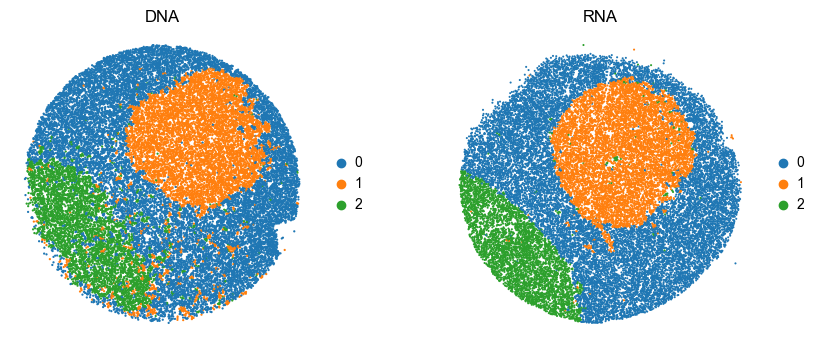

In [23]:
sc.tl.leiden(combined, random_state=666, key_added="leiden", resolution=0.05)
strna.obs['leiden'] = combined.obs['leiden'][combined.obs['Batch']=='RNA'].values
stdna.obs['leiden'] = combined.obs['leiden'][combined.obs['Batch']=='DNA'].values

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams["figure.figsize"] = (2, 2)
plt.rcParams['font.size'] = 10
plt.rcParams['legend.handletextpad'] = 0.01
spot_size = 30
title_size = 15
fig, ax = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'wspace': 0.3, 'hspace': 0.1})

sc.pl.spatial(stdna, color='leiden', cmap="viridis", show=False, frameon=False, spot_size=25,title='DNA', ax=ax[0])
sc.pl.spatial(strna, color='leiden', cmap="viridis", show=False, frameon=False, spot_size=35,title='RNA', ax=ax[1])

plt.show() 

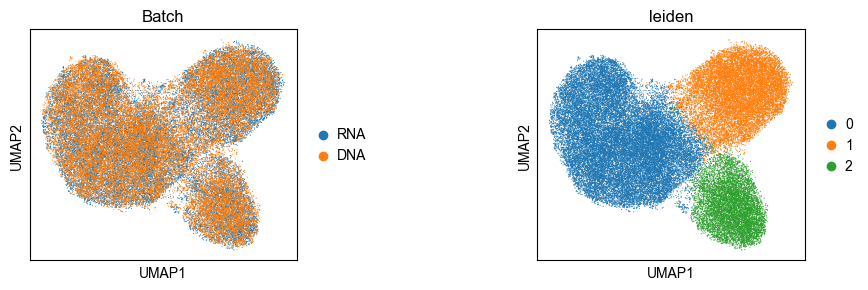

In [24]:
sc.tl.umap(combined)

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams["figure.figsize"] = (2, 2)
plt.rcParams['font.size'] = 10
plt.rcParams['legend.handletextpad'] = 0.01

spot_size = 30
title_size = 15
fig, ax = plt.subplots(1, 2, figsize=(10, 3), gridspec_kw={'wspace': 0.9, 'hspace': 0.1})

sc.pl.umap(combined, color=["Batch"], wspace=1, legend_fontsize=10, show=False, ax=ax[0])
sc.pl.umap(combined, color=['leiden'], legend_fontsize=10, show=False, ax=ax[1])   #, legend_loc=None
plt.show()